### General function for cleaning corpus 

In [116]:
from tokenization_bias import main_token

### Clean corpus posts of each company

In [117]:
# Clean corpus posts Asesoftware

asesoftware_posts=main_token("posts.json","descripcion")
print(asesoftware_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['lead trend 2022️artificial intelligence ️data analytics ️rpawhich one implement business', 'almost 2022 want share ai lead trend future year', 'demonstrate method aid mathematician discover new that_s simply amazing thing evolve field', 'limit rpa imagination programmer 🤖 ️can tell we rpa box application carlos castaño valencia diana cristhina pérez pérez fabian esteban peña castillo', 'introduce indoor garden control app ai enjoy fresh vegetable every day let grow 64 plant simultaneously green ai mashable', 'five way al contribute wildlifeconservation 1 vast datum collection 📊 2 study protect specie 🐨 3 track wildlife pattern 📈 4 prediction endanger specie 🐼 5 classify animal specie', 'participant plan_semilla apprenticeship talk experience last month today want thank congratulate effort welcome team 👏 🏻 👏 🏻 👏 🏻thomas clarke rodríguez hernández sebastián_casas castillo leidy romero', 'today welcome new member team complete successfully plan_semilla 💫 plan_semilla apprenticeship star

In [118]:
# Clean corpus posts Globant

globant_posts=main_token("globant_linkedin.json","content")
print(globant_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['⭐ ️ join_we exciting webinar power culture technology achieve success 👉 learn expert 🟢 guibert_englebienne cofounder president x president latam 🟢 adriana sclar cultural hacking studio partner don´t miss opportunity revolutionize approach change culture workplace 🚀 book spot today 18 april 🕒 12pm arg 17pm cet 20pm', 'last decade research develop technology around ai ai enter accelerated phase surprise everyone new way computer interact human take_look ai manifesto statement ethical complexity', 'exciting news thrill announce we ve select market leader among digital engineering service provider late hfs research horizon report recognition lead global analyst firm testament commitment deliver innovative solution client report highlight studio modelbase offering strength include focus provide highquality solution talent management differentiation technology innovationthank glober support client partner trust remain committed push boundary what s possible deliver outstanding result 👉', '

In [119]:
# Clean corpus posts Accenture

accenture_posts=main_token("accenture_linkedin.json","content")
print(accenture_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ready enter virtual world discover new frontier create strong bond brand business profit check full report', 'ever wonder technological advancement today life business tomorrow explore next frontier tech innovation', 'disruptionproof workflow fiction it reality industrial business tool need increase efficiency transparency already learn', 'truly new possibility lie ahead arrive exciting frontier technology innovation explore four trend shape future discover', '🗓 ️ save date key technology trend emerge physical virtual world blend one share reality join_we special event explore trend shape business technology next decade rsvp today', 'next wave business transformation merge digital physical world create radically new opportunity business leader available share 4 digital trend shape future new share reality 🔮', 'invest people reduce impact planet measure value across area business explore drive change make', 'reinvention long onetime execution continuous strategy redefine industry benc

### NLP function

In [120]:
from model_bias import NLP_model

In [121]:
# Models

ASW_model=NLP_model(asesoftware_posts,"biasASW_word2vec.model")
Globant_model=NLP_model(globant_posts,"biasGlobant_word2vec.model")
Accenture_model=NLP_model(accenture_posts,"biasAccenture_word2vec.model")

### Comparition of model and BIAS

In [122]:
from model_bias import word_to_analyze_companies

In [123]:
word_list=['evolve', 'exciting', 'without', 'never', 'point', 'wonder', 'idea', 'excited', 'thought', 'vision', 'medium', 'what', 'moment', 'view', 'advantage', 'analytic', 'shape', 'continue', 'unique', 'society', 'honor', 'stay', 'special', 'include', 'dream', 'speak', 'enhance', 'can', 'require', 'manage', 'invest', '5', 'tell', 'reduce', 've', 'imagine', 'foundation', 'online', 'key', 'capability', 'explain', '🎉', 'author', 'smart', 'congratulation', 'happen', 'allow', 'combine', 'old', 'consider', 'equity', 'difference', 'collection']

for each in word_list:
    word_to_analyze_companies(each,ASW_model,Globant_model,Accenture_model)


----------------------------------------------------------------------------------------
Word:  evolve
ASW:  [('⬇', 0.37427476048469543), ('machine_🦾', 0.3661186993122101), ('computer', 0.35045620799064636), ('make', 0.34706881642341614), ('possible', 0.3408746123313904)]
Globant:  [('begin', 0.1977362036705017), ('finance', 0.1672196239233017), ('improve', 0.14885041117668152), ('siri', 0.14768895506858826), ('different', 0.14414873719215393)]
Accenture:  [('experience', 0.4018668234348297), ('️', 0.3781701326370239), ('change', 0.367184579372406), ('human', 0.3647006154060364), ('need', 0.36452746391296387)]
----------------------------------------------------------------------------------------
Word:  exciting
ASW:  [('start', 0.5007294416427612), ('datum', 0.49794211983680725), ('thank', 0.4960061311721802), ('create', 0.4906785488128662), ('ai', 0.4840147793292999)]
Globant:  [('insight', 0.24014951288700104), ('huffington', 0.23590818047523499), ('opportunity', 0.2351482808589935

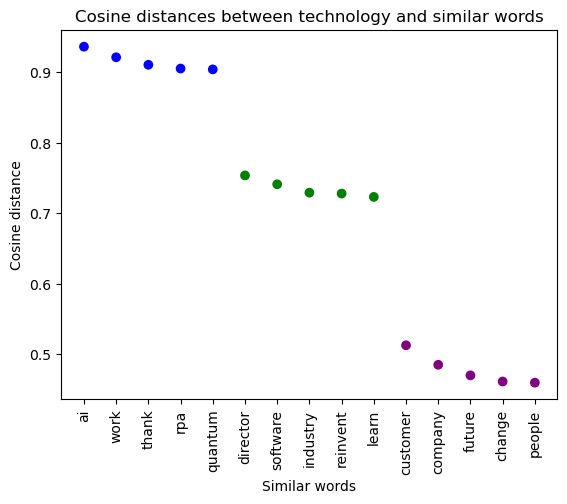

In [124]:
import matplotlib.pyplot as plt

palabra="technology"
# Encuentra las palabras más similares para "data" en cada modelo y calcula las distancias coseno
similaresASW = ASW_model.wv.most_similar(palabra, topn=5)
similaresGlobant = Globant_model.wv.most_similar(palabra, topn=5)
similaresAccenture = Accenture_model.wv.most_similar(palabra, topn=5)

distancias_coseno = [similaresASW[0][1], similaresASW[1][1], similaresASW[2][1], similaresASW[3][1], similaresASW[4][1],
                     similaresGlobant[0][1], similaresGlobant[1][1], similaresGlobant[2][1], similaresGlobant[3][1], similaresGlobant[4][1],
                     similaresAccenture[0][1], similaresAccenture[1][1], similaresAccenture[2][1], similaresAccenture[3][1], similaresAccenture[4][1]]

# Grafica las distancias coseno
nombres_modelos = ["ASW"]*5 + ["Globant"]*5 + ["Accenture"]*5
nombres_palabras_similares = [s[0] for s in similaresASW] + [s[0] for s in similaresGlobant] + [s[0] for s in similaresAccenture]

fig, ax = plt.subplots()
scatter = ax.scatter(nombres_palabras_similares, distancias_coseno, c=["blue"]*5 + ["green"]*5 + ["purple"]*5)

plt.xticks(rotation=90)
plt.title(f"Cosine distances between {palabra} and similar words")
plt.xlabel("Similar words")
plt.ylabel("Cosine distance")
plt.show()


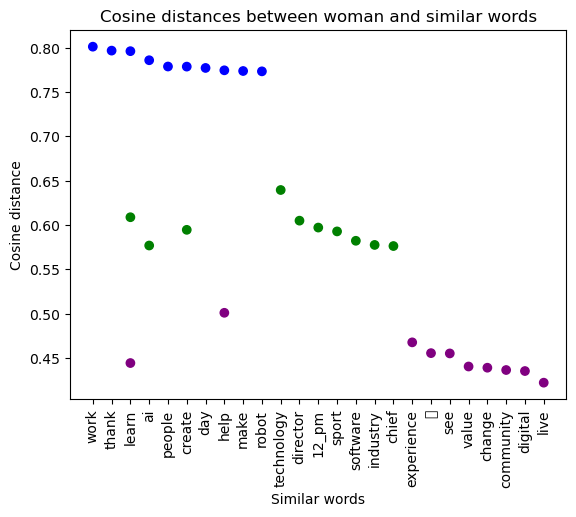

In [125]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

palabra="woman"
top=10
# Encuentra las palabras más similares para "data" en cada modelo y calcula las distancias coseno
similaresASW = ASW_model.wv.most_similar(palabra, topn=top)
similaresGlobant = Globant_model.wv.most_similar(palabra, topn=top)
similaresAccenture = Accenture_model.wv.most_similar(palabra, topn=top)

distancias_coseno = [sim[1] for sim in similaresASW] + [sim[1] for sim in similaresGlobant] + [sim[1] for sim in similaresAccenture]

nombres_palabras_similares = [s[0] for s in similaresASW] + [s[0] for s in similaresGlobant] + [s[0] for s in similaresAccenture]

fig, ax = plt.subplots()
scatter = ax.scatter(nombres_palabras_similares, distancias_coseno, c=["blue"]*top + ["green"]*top + ["purple"]*top)

plt.xticks(rotation=90)
plt.title(f"Cosine distances between {palabra} and similar words")
plt.xlabel("Similar words")
plt.ylabel("Cosine distance")
plt.show()


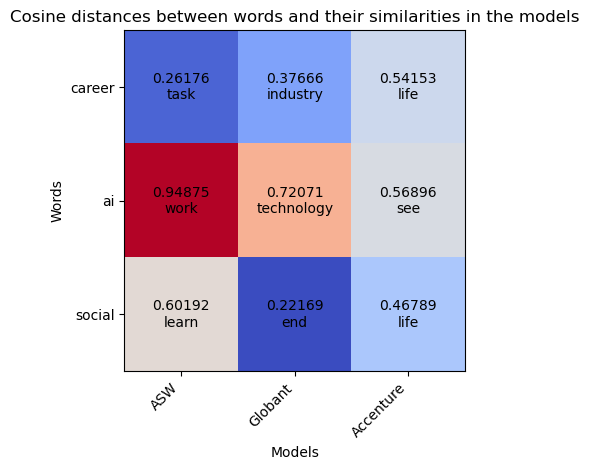

In [126]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

palabras = ["career","ai","social"]

# Obtener las palabras similares y distancias coseno para cada modelo
ASW_similares = [ASW_model.wv.most_similar(p, topn=1) for p in palabras]
ASW_distancias = np.array([[s[1] for s in sim] for sim in ASW_similares])
ASW_palabras = np.array([[s[0] for s in sim] for sim in ASW_similares])

Globant_similares = [Globant_model.wv.most_similar(p, topn=1) for p in palabras]
Globant_distancias = np.array([[s[1] for s in sim] for sim in Globant_similares])
Globant_palabras = np.array([[s[0] for s in sim] for sim in Globant_similares])

Accenture_similares = [Accenture_model.wv.most_similar(p, topn=1) for p in palabras]
Accenture_distancias = np.array([[s[1] for s in sim] for sim in Accenture_similares])
Accenture_palabras = np.array([[s[0] for s in sim] for sim in Accenture_similares])

# Crear una matriz de distancias coseno combinando los tres modelos
distancias_coseno = np.concatenate((ASW_distancias, Globant_distancias, Accenture_distancias), axis=1)
palabras_similares = np.concatenate((ASW_palabras, Globant_palabras, Accenture_palabras), axis=1)

# Crear la figura y el gráfico de calor
fig, ax = plt.subplots()
im = ax.imshow(distancias_coseno, cmap="coolwarm")

# Agregar etiquetas de fila y columna
ax.set_xticks(np.arange(len(palabras)))
ax.set_yticks(np.arange(len(palabras)))
ax.set_xticklabels(["ASW"] + ["Globant"] + ["Accenture"])
ax.set_yticklabels(palabras)

# Rotar las etiquetas del eje x
plt.xticks(rotation=45, ha="right")

# Agregar valores en las celdas
for i in range(len(palabras)):
    for j in range(len(palabras)):
        text = ax.text(j, i, "{:.5f}\n{}".format(distancias_coseno[i, j], palabras_similares[i, j]),
                       ha="center", va="center", color="black")

# Agregar título y mostrar el gráfico
plt.title("Cosine distances between words and their similarities in the models")
plt.xlabel("Models")
plt.ylabel("Words")
plt.tight_layout()
plt.show()



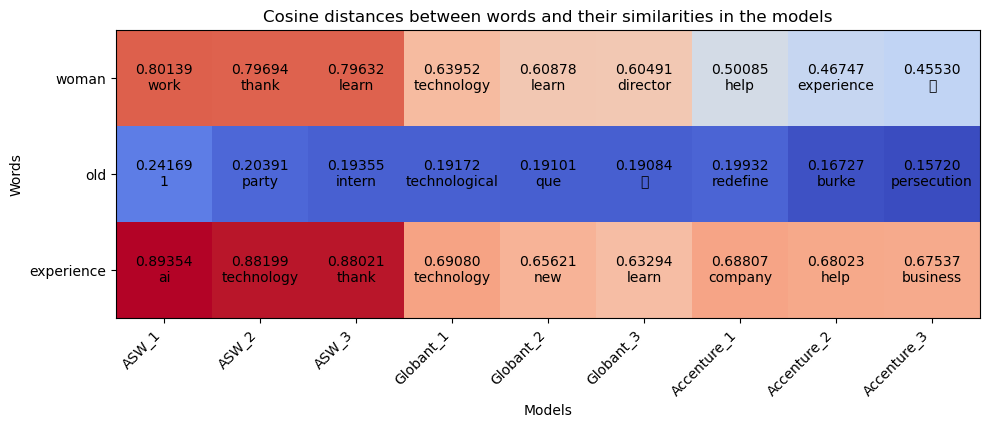

In [127]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

palabras = ['woman', "old", 'experience']

def obtener_similares(modelo, palabras, topn=3):
    """Obtiene las palabras similares y distancias coseno para un modelo y una lista de palabras."""
    similares = [modelo.wv.most_similar(p, topn=topn) for p in palabras]
    distancias = np.array([[s[1] for s in sim] for sim in similares])
    palabras_similares = np.array([[s[0] for s in sim] for sim in similares])
    return distancias, palabras_similares

ASW_distancias, ASW_palabras = obtener_similares(ASW_model, palabras)
Globant_distancias, Globant_palabras = obtener_similares(Globant_model, palabras)
Accenture_distancias, Accenture_palabras = obtener_similares(Accenture_model, palabras)

# Crear una matriz de distancias coseno combinando los tres modelos
distancias_coseno = np.concatenate((ASW_distancias, Globant_distancias, Accenture_distancias), axis=1)
palabras_similares = np.concatenate((ASW_palabras, Globant_palabras, Accenture_palabras), axis=1)

# Crear la figura y el gráfico de calor
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
im = ax.imshow(distancias_coseno, cmap="coolwarm")

# Agregar etiquetas de fila y columna
ax.set_xticks(np.arange(len(palabras) * 3))
ax.set_yticks(np.arange(len(palabras)))
ax.set_xticklabels(["ASW_1", "ASW_2", "ASW_3", "Globant_1", "Globant_2", "Globant_3", "Accenture_1", "Accenture_2", "Accenture_3"])
ax.set_yticklabels(palabras)

# Rotar las etiquetas del eje x
plt.xticks(rotation=45, ha="right")

# Agregar valores en las celdas
for i in range(len(palabras)):
    for j in range(len(palabras) * 3):
        text = ax.text(j, i, "{:.5f}\n{}".format(distancias_coseno[i, j], palabras_similares[i, j]),
                       ha="center", va="center", color="black")

# Agregar título y mostrar el gráfico
plt.title("Cosine distances between words and their similarities in the models")
plt.xlabel("Models")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


In [128]:
word_to_analyze_companies("woman",ASW_model,Globant_model,Accenture_model)

----------------------------------------------------------------------------------------
Word:  woman
ASW:  [('work', 0.8013898730278015), ('thank', 0.7969366908073425), ('learn', 0.7963180541992188), ('ai', 0.7860737442970276), ('people', 0.7789864540100098)]
Globant:  [('technology', 0.6395247578620911), ('learn', 0.6087778210639954), ('director', 0.6049051284790039), ('12_pm', 0.597098708152771), ('create', 0.5945446491241455)]
Accenture:  [('help', 0.5008509755134583), ('experience', 0.46746736764907837), ('💜', 0.4553026854991913), ('see', 0.4549620449542999), ('learn', 0.44410645961761475)]


In [129]:
def distances_to_target_gender(target, ASW_model, Globant_model, Accenture_model):
    ASW_d_1=ASW_model.wv.distance("woman",target)
    ASW_d_2=ASW_model.wv.distance("man",target)
    Globant_d_1=Globant_model.wv.distance("woman",target)
    Globant_d_2=Globant_model.wv.distance("mens",target)
    Accenture_d_1=Accenture_model.wv.distance("woman",target)
    Accenture_d_2=Accenture_model.wv.distance("man",target)

    print(f"\n Word: {target}\n")
    print(f"Distances 'woman' with {target}:")
    print("ASW: {:.4f}, Globant: {:.4f}, Accenture: {:.4f}".format(ASW_d_1, Globant_d_1, Accenture_d_1))
    print(f"Distances with 'man' with {target} :")
    print("ASW: {:.4f}, Globant: {:.4f}, Accenture: {:.4f}".format(ASW_d_2, Globant_d_2, Accenture_d_2))

def distances_between_targets(target1, target2, ASW_model, Globant_model, Accenture_model):
    ASW_d_1 = ASW_model.wv.distance(target1, target2)
    Globant_d_1 = Globant_model.wv.distance(target1, target2)
    Accenture_d_1 = Accenture_model.wv.distance(target1, target2)

    print(f"\n Distances {target1} with {target2}:\n")
    print("ASW: {:.4f}, Globant: {:.4f}, Accenture: {:.4f}".format(ASW_d_1, Globant_d_1, Accenture_d_1))




In [144]:
distances_to_target_gender("experience", ASW_model, Globant_model, Accenture_model)
distances_to_target_gender("old", ASW_model, Globant_model, Accenture_model)
distances_to_target_gender("intelligence", ASW_model, Globant_model, Accenture_model)
distances_to_target_gender("opportunity", ASW_model, Globant_model, Accenture_model)
distances_to_target_gender("social", ASW_model, Globant_model, Accenture_model)
distances_to_target_gender("listen", ASW_model, Globant_model, Accenture_model)



 Word: experience

Distances 'woman' with experience:
ASW: 0.2514, Globant: 0.4429, Accenture: 0.5325
Distances with 'man' with experience :
ASW: 0.8079, Globant: 0.9271, Accenture: 0.8954

 Word: old

Distances 'woman' with old:
ASW: 0.8677, Globant: 0.9364, Accenture: 1.0216
Distances with 'man' with old :
ASW: 0.9241, Globant: 0.9398, Accenture: 1.0088

 Word: intelligence

Distances 'woman' with intelligence:
ASW: 0.5809, Globant: 0.7487, Accenture: 0.7446
Distances with 'man' with intelligence :
ASW: 0.9036, Globant: 0.9278, Accenture: 0.8644

 Word: opportunity

Distances 'woman' with opportunity:
ASW: 0.2805, Globant: 0.4601, Accenture: 0.8030
Distances with 'man' with opportunity :
ASW: 0.8231, Globant: 0.8871, Accenture: 0.9548

 Word: social

Distances 'woman' with social:
ASW: 0.4895, Globant: 0.8449, Accenture: 0.6763
Distances with 'man' with social :
ASW: 0.8940, Globant: 0.9151, Accenture: 0.8453

 Word: listen

Distances 'woman' with listen:
ASW: 0.6754, Globant: 0.569

In [131]:
distances_between_targets("opportunity", "experience", ASW_model, Globant_model, Accenture_model)
distances_between_targets("opportunity", "old", ASW_model, Globant_model, Accenture_model)
distances_between_targets("career", "grow", ASW_model, Globant_model, Accenture_model)
distances_between_targets("ai", "smart", ASW_model, Globant_model, Accenture_model)
distances_between_targets("team", "technology", ASW_model, Globant_model, Accenture_model)
distances_between_targets("equity", "career", ASW_model, Globant_model, Accenture_model)
distances_between_targets("equity", "gender", ASW_model, Globant_model, Accenture_model)
distances_between_targets("culture", "technology", ASW_model, Globant_model, Accenture_model)



 Distances opportunity with experience:

ASW: 0.2410, Globant: 0.4872, Accenture: 0.6993

 Distances opportunity with old:

ASW: 0.8544, Globant: 1.0343, Accenture: 0.8726

 Distances career with grow:

ASW: 0.8286, Globant: 0.8778, Accenture: 0.7415

 Distances ai with smart:

ASW: 0.9722, Globant: 0.6709, Accenture: 0.9419

 Distances team with technology:

ASW: 0.1148, Globant: 0.4275, Accenture: 0.6301

 Distances equity with career:

ASW: 0.8596, Globant: 1.0237, Accenture: 0.8751

 Distances equity with gender:

ASW: 0.8413, Globant: 0.9108, Accenture: 0.9568

 Distances culture with technology:

ASW: 0.5842, Globant: 0.6498, Accenture: 0.6590


In [132]:
# Get the most common words for each model

ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Find the common words across all 3 models
common_words = set(ASW_common) & set(Globant_common) & set(Accenture_common)

# Print the common words for each model and the common words across all 3 models
print("ASW common words:", ASW_common)
print("Globant common words:", Globant_common)
print("Accenture common words:", Accenture_common)
print("Common words across all 3 models:", common_words)


ASW common words: ['ai', 'work', 'thank', 'use', 'want', 'learn', 'design', 'technology', 'we', 'datum', 'team', 'start', 'year', 'make', 'new', '️', 'create', 'business', 'human', 'think', 'help', 'machine', 'day', 'one', 'robot', 'quantum', 'love', 'write', 'experience', 'solution', 'model', 'like', 'today', 'know', 'could', 'understand', 'good', 'quantum_computing', 'artificial_intelligence', 'article', 'rpa', 'lab', 'data', 'time', 'course', 'talk', 'need', 'company', 'apply', 'process', '🖤', 'user', 'well', 'people', 'read', 'asesoftware', 'information', 'way', 'first', 'improve', 'industry', 'job', 'video', 'week', '💪', 'want_know', 'enjoy', 'two', 'get', 'class', 'happy', 'let', 'world', 'build', 'different', 'check', 'last', 'share', 'come', 'change', 'application', 'knowledge', 'iván_caballero', 'contact_we', 'designer', 'daily', 'challenge', 'science', 'together', 'holistic_design', 'take', 'fact', '👏', 'become', 'project', 'three', 'feel', 'next', 'al', 'ai_designer', 'autom

In [133]:
from collections import defaultdict
# Get the most common words for each model

ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Find the common words across all 3 models
common_words = set(ASW_common) & set(Globant_common) & set(Accenture_common)

# Create a dictionary of word frequencies
freq_dict = defaultdict(int)
for word in common_words:
    freq_dict[word] += 1

# Sort the dictionary by frequency and create a list of the top 100 words
sorted_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
top_words = [w[0] for w in sorted_words]

# Print the top 100 common words
print("Top common words:", top_words)

Top common words: ['thing', 'evolve', 'provide', 'role', 'business', 'speaker', 'human', 'solution', 'boost', 'tune', 'give', 'trend', 'support', 'exciting', 'year', 'ever', 'create', 'career', 'develop', 'happy', 'grow', 'without', 'become', 'big', 'focus', 'everyone', 'never', 'art', 'point', 'read', 'opportunity', 'wonder', '️', '6', 'favorite', 'today', 'help', 'week', 'idea', 'drive', 'gender', 'highlight', 'woman', 'late', 'product', 's', 'build', 'excited', 'thought', 'miss', 'vision', 'go', 'life', 'see', 'medium', 'understand', 'what', 'app', 'moment', 'increase', 'first', 'view', '2023', 'we', 'advantage', 'strategy', 'check', 'analytic', 'shape', 'story', 'continue', 'use', 'unique', 'possible', 'application', 'celebrate', 'offer', 'society', 'hear', 'honor', 'science', 'stay', 'game', 'tool', 'part', '2022', 'love', 'special', 'place', 'include', '🙌', 'keep', 'next', 'result', 'dream', 'speak', 'also', 'goal', 'full', 'end', 'program', 'meet', 'show', 'change', 'enhance', '

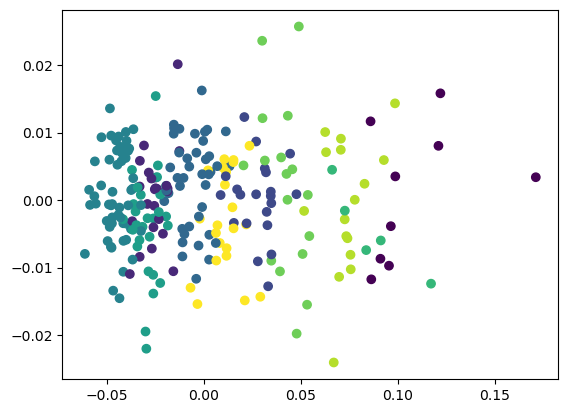

In [134]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Get the word vectors for the common words across all 3 models
common_word_vectors = []
for word in top_words:
    common_word_vectors.append(
        ASW_model.wv.get_vector(word) + 
        Globant_model.wv.get_vector(word) + 
        Accenture_model.wv.get_vector(word)
    )
    

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
common_word_vectors_pca = pca.fit_transform(common_word_vectors)

# aplicar k-means
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(common_word_vectors)

# graficar los resultados de k-means
plt.scatter(common_word_vectors_pca[:, 0], common_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Print the most common clusters
cluster_counts = defaultdict(int)
for i in range(len(top_words)):
    cluster_counts[kmeans.labels_[i]] += 1


In [135]:
words_in_clusters = defaultdict(list)
for i, word in enumerate(top_words):
    words_in_clusters[kmeans.labels_[i]].append(word)
    
most_common_clusters = sorted(words_in_clusters.items(), key=lambda x: len(x[1]), reverse=True)

for cluster, words in most_common_clusters:
    print(f"Cluster {cluster}: {words}")


Cluster 4: ['evolve', 'exciting', 'without', 'never', 'point', 'wonder', 'idea', 'excited', 'thought', 'vision', 'medium', 'what', 'moment', 'view', 'advantage', 'analytic', 'shape', 'continue', 'unique', 'society', 'honor', 'stay', 'special', 'include', 'dream', 'speak', 'enhance', 'can', 'require', 'manage', 'invest', '5', 'tell', 'reduce', 've', 'imagine', 'foundation', 'online', 'key', 'capability', 'explain', '🎉', 'author', 'smart', 'congratulation', 'happen', 'allow', 'combine', 'old', 'consider', 'equity', 'difference', 'collection']
Cluster 3: ['thing', 'support', 'develop', 'focus', 'everyone', 'week', 'drive', 'product', 'miss', 'go', '2023', 'possible', 'application', 'celebrate', 'hear', 'place', 'result', 'service', 'sport', '👏', 'insight', 'great', 'journey', 'platform', 'inspire', 'designer', 'research', 'professional', 'project', 'culture', 'even', 'innovation', 'every', 'ready', 'lead', 'last', 'step', 'community', 'metaverse', 'around', 'transform']
Cluster 5: ['provi

# Unique data ASW

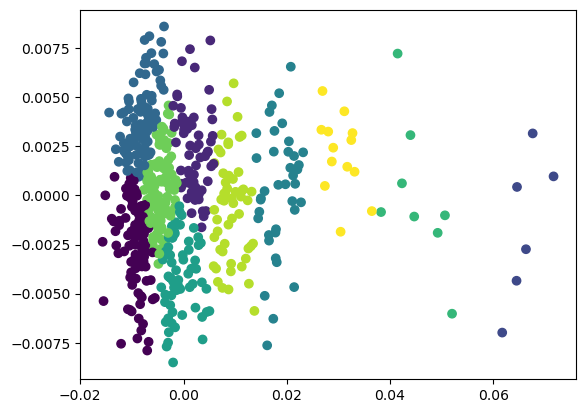

In [136]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Obtener las palabras más comunes en cada modelo de forma individual.
ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Encontrar las palabras únicas en cada modelo que no estén presentes en los otros modelos.
ASW_unique = set(ASW_common) - set(Globant_common) - set(Accenture_common)
#Globant_unique = set(Globant_common) - set(ASW_common) - set(Accenture_common)
#Accenture_unique = set(Accenture_common) - set(ASW_common) - set(Globant_common)

# Calcular los vectores de palabras para cada conjunto de palabras únicas.
ASW_vectors = [ASW_model.wv.get_vector(word) for word in ASW_unique]
#Globant_vectors = [Globant_model.wv.get_vector(word) for word in Globant_unique]
#Accenture_vectors = [Accenture_model.wv.get_vector(word) for word in Accenture_unique]

# Combinar los vectores de palabras en una lista.
#unique_word_vectors = ASW_vectors + Globant_vectors + Accenture_vectors

unique_word_vectors = ASW_vectors

# Reducir la dimensionalidad de los vectores utilizando PCA.
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Aplicar k-means para encontrar clusters.
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# graficar los resultados de k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Asignar etiquetas a cada palabra única según el cluster correspondiente.
labels = defaultdict(str)
for i, word in enumerate(ASW_unique):
    labels[word] = "ASW"
#for i, word in enumerate(Globant_unique):
    #labels[word] = "Globant"
#for i, word in enumerate(Accenture_unique):
    #labels[word] = "Accenture"



In [137]:
# Obtener las etiquetas de cada palabra única según el cluster correspondiente.
word_labels = kmeans.labels_

# Crear un diccionario que asocie cada etiqueta con las palabras correspondientes.
cluster_words = defaultdict(list)
for i, word in enumerate(ASW_unique):
    cluster_words[word_labels[i]].append(word)

# Imprimir las palabras de cada cluster.
for cluster_label, words in cluster_words.items():
    print("Cluster ", cluster_label)
    print(words)


Cluster  1
['sara', '️she', 'chocolate', 'implementation', 'recommend', 'blog', 'hand', 'since', 'later', 'november', 'defeat', 'avoid', 'complex', 'battle', 'diaz', 'qc', 'character', 'mechanic', 'colombia', 'touch', 'survivor', 'quantum_compute', 'chatbot', '️do', 'analyze', 'python', 'london_tech', 'try', '️we', '🍿', 'let_work', 'valencia', 'participant', 'maría', 'film', 'trading', 'able', 'sure', 'delgado', '☀', 'context', '♟', '🔬', 'fight', 'famous', 'man_behind', 'mountain', 'friendship', '⚛', '💡', 'cristhina', 'wand', 'abstract', '👣', '🧠', 'arturo', 'romero', 'rodriguez', 'relevant', 'small', 'prakash', 'analyst', 'advanced', 'velásquez', 'work_together']
Cluster  7
['corner', '20', 'researcher', '🕵', '🎶', 'organisation', '⏰', 'nicolás', 'immerse', 'drug', 'accurate', 'requirement', 'effect', 'simple', 'programme', 'cycle', '⚠', 'empathy', '😂', 'uk', 'response', 'oscar', 'gonzález', 'consist', 'weekend', 'camila', 'specify', 'iván', 'increasingly', 'vast', '🦰', 'qubit', 'proper

## Unique data Globant

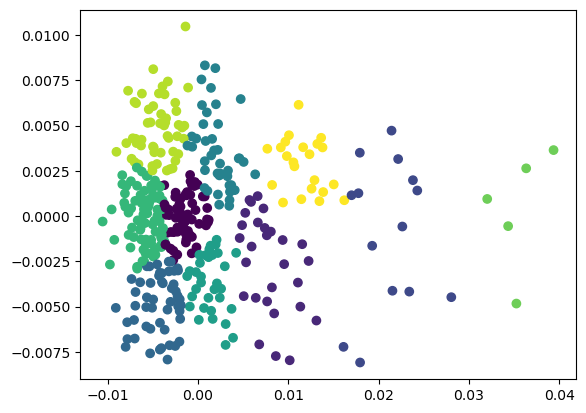

In [138]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Obtener las palabras más comunes en cada modelo de forma individual.
ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Encontrar las palabras únicas en cada modelo que no estén presentes en los otros modelos.
#ASW_unique = set(ASW_common) - set(Globant_common) - set(Accenture_common)
Globant_unique = set(Globant_common) - set(ASW_common) - set(Accenture_common)
#Accenture_unique = set(Accenture_common) - set(ASW_common) - set(Globant_common)

# Calcular los vectores de palabras para cada conjunto de palabras únicas.
#ASW_vectors = [ASW_model.wv.get_vector(word) for word in ASW_unique]
Globant_vectors = [Globant_model.wv.get_vector(word) for word in Globant_unique]
#Accenture_vectors = [Accenture_model.wv.get_vector(word) for word in Accenture_unique]

# Combinar los vectores de palabras en una lista.
#unique_word_vectors = ASW_vectors + Globant_vectors + Accenture_vectors

unique_word_vectors = Globant_vectors

# Reducir la dimensionalidad de los vectores utilizando PCA.
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Aplicar k-means para encontrar clusters.
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# graficar los resultados de k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Asignar etiquetas a cada palabra única según el cluster correspondiente.
labels = defaultdict(str)
#for i, word in enumerate(ASW_unique):
    #labels[word] = "ASW"
for i, word in enumerate(Globant_unique):
    labels[word] = "Globant"
#for i, word in enumerate(Accenture_unique):
    #labels[word] = "Accenture"


In [139]:
# Obtener las etiquetas de cada palabra única según el cluster correspondiente.
word_labels = kmeans.labels_

# Crear un diccionario que asocie cada etiqueta con las palabras correspondientes.
cluster_words = defaultdict(list)
for i, word in enumerate(Globant_unique):
    cluster_words[word_labels[i]].append(word)

# Imprimir las palabras de cada cluster.
for cluster_label, words in cluster_words.items():
    print("Cluster ", cluster_label)
    print(words)

Cluster  0
['java', '🇵', 'celebration', 'young', 'mesmo', 'upcoming', 'center', 'acquisition', 'esta', 'morettini', 'coachhub', '🟢', 'andrea', 'código', 'fácil', 'perception', 'unlimited', 'kun', 'behind', 'unprecedented', 'bertalan', 'linkedin', 'washington', 'forum', 'buenos', 'media', '14', 'pessoas', 'foster', 'futaoka', 'lineup', '🇬', 'kathy', 'perfect', 'aipowered', '️take', 'tendências', 'pardo', 'latam', 'stigma', 'na', 'autonomous', 'generative', 'lowcode', 'vamos', 'stream', 'sclar', 'announcement', 'official', 'camp', 'quo', 'someone', 'syndrome', 'turingbot', 'sandbox', '🗣', 'saint', 'linguagem', 'gialain', 'low', 'melissa', 'pick', 'datadriven', 'weigert', 'schneider', 'dados', 'martin', 'mudar', 'entire']
Cluster  2
['para', 'fifa', 'cofounder', 'executive', 'edt_1', 'blockchain', '▸', 'session', 'head', 'pm_art', '🇷', 'guibert_englebienne', 'tech_trend', 'nov_3']
Cluster  4
['clippers', 'player', 'intuit', 'salesforce', 'regional', 'reinforce', '🇦', 'óscar', 'overcome', 

## Unique data accenture

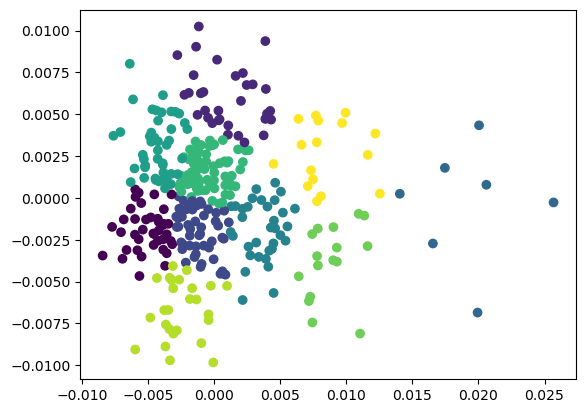

In [140]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Obtener las palabras más comunes en cada modelo de forma individual.
ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Encontrar las palabras únicas en cada modelo que no estén presentes en los otros modelos.
#ASW_unique = set(ASW_common) - set(Globant_common) - set(Accenture_common)
#Globant_unique = set(Globant_common) - set(ASW_common) - set(Accenture_common)
Accenture_unique = set(Accenture_common) - set(ASW_common) - set(Globant_common)

# Calcular los vectores de palabras para cada conjunto de palabras únicas.
#ASW_vectors = [ASW_model.wv.get_vector(word) for word in ASW_unique]
#Globant_vectors = [Globant_model.wv.get_vector(word) for word in Globant_unique]
Accenture_vectors = [Accenture_model.wv.get_vector(word) for word in Accenture_unique]

# Combinar los vectores de palabras en una lista.
#unique_word_vectors = ASW_vectors + Globant_vectors + Accenture_vectors

unique_word_vectors = Accenture_vectors

# Reducir la dimensionalidad de los vectores utilizando PCA.
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Aplicar k-means para encontrar clusters.
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# graficar los resultados de k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Asignar etiquetas a cada palabra única según el cluster correspondiente.
labels = defaultdict(str)
#for i, word in enumerate(ASW_unique):
    #labels[word] = "ASW"
#for i, word in enumerate(Globant_unique):
    #labels[word] = "Globant"
for i, word in enumerate(Accenture_unique):
    labels[word] = "Accenture"

In [141]:
# Obtener las etiquetas de cada palabra única según el cluster correspondiente.
word_labels = kmeans.labels_

# Crear un diccionario que asocie cada etiqueta con las palabras correspondientes.
cluster_words = defaultdict(list)
for i, word in enumerate(Accenture_unique):
    cluster_words[word_labels[i]].append(word)

# Imprimir las palabras de cada cluster.
for cluster_label, words in cluster_words.items():
    print("Cluster ", cluster_label)
    print(words)

Cluster  6
['illuminate', 'internal', 'reimagine', 'dr', 'shop', 'east', 'vital', 'sanjeev', 'kapoor', 'kaustuv', 'wallet', 'chart', 'impactful', 'airline', 'hunger', 'upskilling', '2050', 'guan', '10yearold', 'description', 'holistic', 'lgbtiq', 'consecutive', 'revel', 'samta', 'provider', 'deal', 'all', 'screen', 'sign', 'exponential', 'reflect', 'speed', 'limit', 'safety', 'electric', 'proactive', 'hyperloop', 'fade', 'strength', 'cloudbase', 'positioned', 'davos', 'felix', 'crisis', 'direct', 'digitize', 'tap', '🛍', 'seamlessly', 'getting', 'lack', 'transition', 'victim', 'pride', 'differently', 'toward', 'tough', 'persecution', 'dimension', 'holocaust', 'operating', 'asia', 'simplify', 'jack', 'address', 'responsibly', 'beck', 'purpose']
Cluster  2
['host', 'ireland', 'artist', 'tedx', 'importantly', 'song', '🎧', 'logementschl', 'massive', 'protect', 'dhypothèques', 'sleep', 'creator', 'billion', '°', 'worker', 'bingo', 'web', 'endless', 're', 'cool', 'line', 'gap', 'purple', 'cha

### 3 uniques

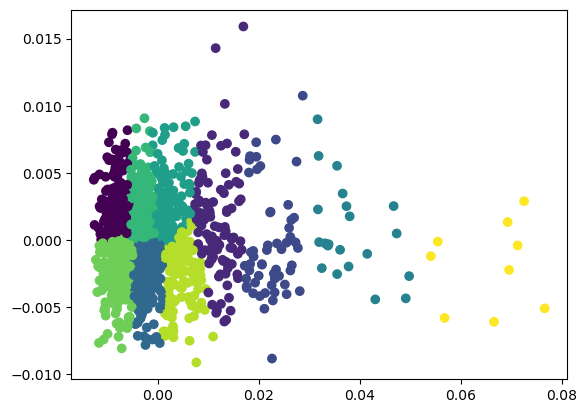

sara: ASW
java: Globant
corner: ASW
warm: ASW
para: Globant
host: Accenture
clippers: Globant
podemos: Globant
socialize: Accenture
prediction: ASW
counting: ASW
annual: Accenture
dr: Accenture
researcher: ASW
celebration: Globant
ireland: Accenture
ureta: Globant
➡: Globant
sebastián: ASW
scientific: ASW
barcelona: Accenture
vital: Accenture
qa: Globant
movement: ASW
deepfake: Accenture
organisation: ASW
supermodel: Globant
nicolás: ASW
nyse: Globant
leap: Accenture
✏: Globant
alvaro: Globant
📊: ASW
criar: Globant
stage: Globant
upcoming: Globant
wing: Accenture
food: Accenture
enthusiasm: ASW
drug: ASW
interpret: ASW
contraception: ASW
et: Accenture
jose: Globant
selection: ASW
blog: ASW
return: Accenture
4th: ASW
maximize: Globant
intuit: Globant
fundamental: ASW
recognise: ASW
sanjeev: Accenture
hand: ASW
assist: ASW
animal: ASW
champion: Accenture
since: ASW
kapoor: Accenture
parent: ASW
🗓: Globant
measure: Accenture
2and: ASW
programme: ASW
bozoma: Globant
pioneer: Globant
salesf

In [142]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

# Get the unique words for each model
ASW_unique = set(ASW_model.wv.index_to_key) - set(Globant_model.wv.index_to_key) - set(Accenture_model.wv.index_to_key)
Globant_unique = set(Globant_model.wv.index_to_key) - set(ASW_model.wv.index_to_key) - set(Accenture_model.wv.index_to_key)
Accenture_unique = set(Accenture_model.wv.index_to_key) - set(ASW_model.wv.index_to_key) - set(Globant_model.wv.index_to_key)

# Get the word vectors for the unique words across each model
unique_word_vectors = []
for word in ASW_unique:
    unique_word_vectors.append(ASW_model.wv.get_vector(word))
for word in Globant_unique:
    unique_word_vectors.append(Globant_model.wv.get_vector(word))
for word in Accenture_unique:
    unique_word_vectors.append(Accenture_model.wv.get_vector(word))

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Apply k-means
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# Plot the results of k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Assign labels to each unique word according to the corresponding cluster.
labels = defaultdict(str)
for i, word in enumerate(ASW_unique):
    labels[word] = "ASW"
for i, word in enumerate(Globant_unique):
    labels[word] = "Globant"
for i, word in enumerate(Accenture_unique):
    labels[word] = "Accenture"

# Print the unique words and their corresponding company.
for i, word in enumerate(ASW_unique | Globant_unique | Accenture_unique):
    print(f"{word}: {labels[word]}")

# Print the most common clusters for each company
for company, unique_words in [("ASW", ASW_unique), ("Globant", Globant_unique), ("Accenture", Accenture_unique)]:
    company_word_vectors = []
    for word in unique_words:
        company_word_vectors.append(ASW_model.wv.get_vector(word) if company == "ASW" else
                                     Globant_model.wv.get_vector(word) if company == "Globant" else
                                     Accenture_model.wv.get_vector(word))
    
    company_word_vectors_pca = pca.transform(company_word_vectors)
    kmeans_labels = kmeans.predict(company_word_vectors_pca)
    company_cluster_counts = defaultdict(int)
    for i in range(len(unique_words)):
        company_cluster_counts[kmeans_labels[i]] += 1
    company_words_in_clusters = defaultdict(list)
    for i, word in enumerate(unique_words):
        company_words_in_clusters[kmeans_labels[i]].append(word)
    company_most_common_clusters = sorted(company_words_in_clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    print(f"Most common clusters for {company}:")
    for cluster, words in company_most_common_clusters:
        print(f"Cluster {cluster}: {words}")
